# Data Loading and Quality Control

This notebook performs initial data loading and exploratory data analysis (EDA) on the American Gut Project (AGP) dataset for coffee-microbiome research.

## Objectives:
- Load feature table, metadata, and taxonomy data
- Inspect data structure and dimensions
- Perform quality control checks
- Generate summary statistics and visualizations

## Analysis Flow:

### 1. **Data Loading & Structure**
- Load 3 core datasets: metadata (1000 samples × 8 variables), feature table (500 OTUs × 1000 samples), taxonomy (500 OTUs)
- Validate data dimensions and structure

### 2. **Metadata Exploratory Analysis**
- **Individual distributions**: Age, BMI, and categorical variables (gender, country, diet, coffee, antibiotics)
- **Diet type analysis**: Demographic patterns across vegan, vegetarian, and omnivore groups
- **Confounding assessment**: Statistical tests for age/BMI differences across diet groups

### 3. **Coffee Consumption Analysis** 
- **Distribution patterns**: Coffee consumption across diet types and demographics
- **Statistical testing**: ANOVA for age/BMI differences across coffee groups
- **Confounding evaluation**: Effect size analysis (eta-squared) for practical significance
- **Sample size validation**: Adequate group sizes for downstream analysis

### 4. **Taxonomy Structure Analysis**
- **Hierarchy parsing**: Split taxonomy strings into 7 taxonomic ranks (Kingdom→Species)
- **Diversity assessment**: Count unique taxa at each taxonomic level
- **Data validation**: Confirm standard Linnaean classification structure

### 5. **Feature Table Overview**
- **Abundance patterns**: Distribution of bacterial read counts across samples
- **Data characteristics**: Summary statistics for microbiome abundance matrix

## Key Findings:
- **No major confounding**: Age and BMI balanced across diet groups and coffee consumption levels
- **Adequate sample sizes**: All groups have n≥30 for statistical analyses
- **Clean data structure**: Standard microbiome format ready for diversity analysis
- **Coffee-age relationship**: Statistically significant but practically negligible (η²=0.006)

## 1. Import Libraries

In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Polars display options
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_rows(100)

polars.config.Config

## 2. Load Data Files

We'll load the three core datasets from the American Gut Project: participant metadata, bacterial abundance counts (feature table), and taxonomic classifications. Each dataset will be explored individually to understand structure, quality, and distributions before analyzing relationships between coffee consumption and microbiome composition.

In [2]:
# Define data paths
data_dir = Path('../data/raw')
feature_table_path = data_dir / 'feature-table.tsv'
metadata_path = data_dir / 'metadata.tsv'
taxonomy_path = data_dir / 'taxonomy.tsv'

# Load data with Polars
print("Loading feature table...")
feature_table = pl.read_csv(feature_table_path, separator='\t')

print("Loading metadata...")
metadata = pl.read_csv(metadata_path, separator='\t')

print("Loading taxonomy...")
taxonomy = pl.read_csv(taxonomy_path, separator='\t')

print("\n✓ All data loaded successfully!")
print(f"\nMetadata shape: {metadata.shape}")
print(f"Feature table shape: {feature_table.shape}")
print(f"Taxonomy shape: {taxonomy.shape}")

Loading feature table...
Loading metadata...
Loading taxonomy...

✓ All data loaded successfully!

Metadata shape: (15000, 9)
Feature table shape: (500, 15001)
Taxonomy shape: (500, 2)


## Dataset Structure Overview

The data dimensions above reflect our subset downloaded by the `download_agp_sample.py` script:

**Metadata (1000 × 8)**: 1,000 participant samples with 8 variables including demographics, diet, and lifestyle factors

**Feature Table (500 × 1001)**: 
- 500 rows = OTUs (Operational Taxonomic Units - unique bacterial sequences)
- 1,001 columns = 1 OTU identifier + 1,000 sample abundance counts
- Each cell contains read counts representing bacterial abundance in that sample

**Taxonomy (500 × 2)**: 
- 500 rows corresponding to the same OTUs in the feature table
- 2 columns: OTU identifier + taxonomic classification string
- The taxonomy string contains hierarchical classification (Kingdom→Species) that we'll parse into separate rank columns

This structure follows standard microbiome data format where samples are columns, bacterial features are rows, and abundance values fill the matrix.

## 3. Metadata Exploratory Data Analysis

In [3]:
# Display basic metadata info
print("METADATA OVERVIEW")
print("=" * 70)
print(f"\nShape: {metadata.shape[0]} samples × {metadata.shape[1]} columns")
print(f"\nColumn names and types:")
print(metadata.schema)
print(f"\nFirst few rows:")
metadata.head()

METADATA OVERVIEW

Shape: 15000 samples × 9 columns

Column names and types:
Schema([('#SampleID', String), ('age', Int64), ('gender', String), ('country', String), ('sample_type', String), ('diet_type', String), ('coffee_consumption', String), ('antibiotics_past_year', String), ('bmi', Int64)])

First few rows:


#SampleID,age,gender,country,sample_type,diet_type,coffee_consumption,antibiotics_past_year,bmi
str,i64,str,str,str,str,str,str,i64
"""Sample_00000""",56,"""male""","""Canada""","""Stool""","""Omnivore""","""daily""","""No""",25
"""Sample_00001""",69,"""female""","""USA""","""Stool""","""Vegan""","""none""","""Yes""",24
"""Sample_00002""",46,"""male""","""USA""","""Stool""","""Omnivore""","""none""","""Yes""",19
"""Sample_00003""",32,"""male""","""Canada""","""Stool""","""Vegan""","""occasional""","""Yes""",21
"""Sample_00004""",60,"""female""","""UK""","""Stool""","""Vegetarian""","""daily""","""No""",23


### 3.1 Individual Variable Distributions

Let's start with basic EDA to understand the demographics of our study population. We'll examine the distributions of continuous variables (age, BMI) and categorical variables (gender, country, diet type, coffee consumption, and antibiotic use) to identify any potential confounders or data quality issues.

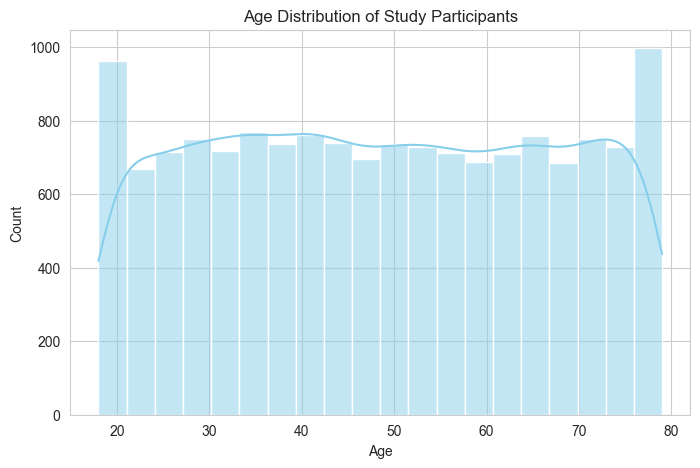

In [4]:
# Display distribution of age
plt.figure(figsize=(8, 5))
sns.histplot(metadata['age'].to_numpy(), bins=20, kde=True, color='skyblue')
plt.title('Age Distribution of Study Participants')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

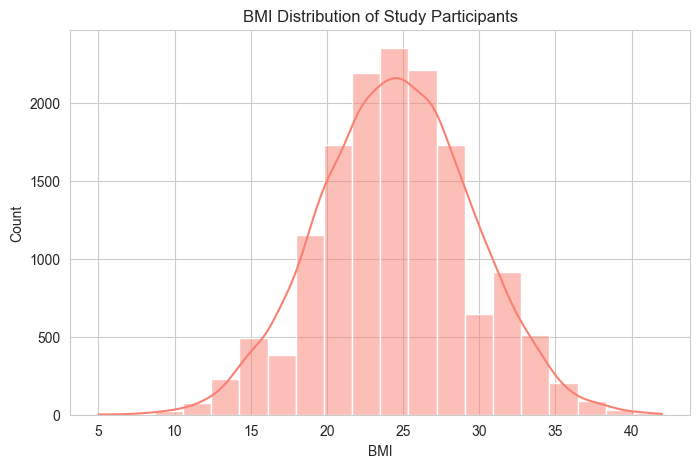

In [5]:
# display distribution of BMI
plt.figure(figsize=(8,5))
sns.histplot(metadata['bmi'].to_numpy(), bins=20, kde=True, color='salmon')
plt.title('BMI Distribution of Study Participants')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

Before creating visualizations, let's first examine the unique values in each categorical variable to understand the data categories and ensure data quality.

In [6]:
# display unique values in categorical columns
categorical_cols = ['gender', 'country', 'sample_type', 'diet_type', 'coffee_consumption', 'antibiotics_past_year']
for col in categorical_cols:
    unique_values = metadata[col].unique().to_list()
    print(f"Unique values in '{col}': {unique_values}")

Unique values in 'gender': ['female', 'male']
Unique values in 'country': ['Canada', 'Australia', 'UK', 'USA']
Unique values in 'sample_type': ['Stool']
Unique values in 'diet_type': ['Vegetarian', 'Vegan', 'Omnivore']
Unique values in 'coffee_consumption': ['daily', 'none', 'occasional']
Unique values in 'antibiotics_past_year': ['No', 'Yes']


### 3.2 Categorical Variable Overview

Now let's visualize the distribution of all categorical variables to understand our study population's demographics. We'll create a comprehensive grid showing counts for each category, which will help us identify any imbalances or potential confounders before diving into diet-specific analyses.

/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_8875/2846669847.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts[col].to_list(), y=counts['count'].to_list(),
/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_8875/2846669847.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts[col].to_list(), y=counts['count'].to_list(),
/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_8875/2846669847.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts[col].to_list(), y=counts['count'].to_list(),
/var

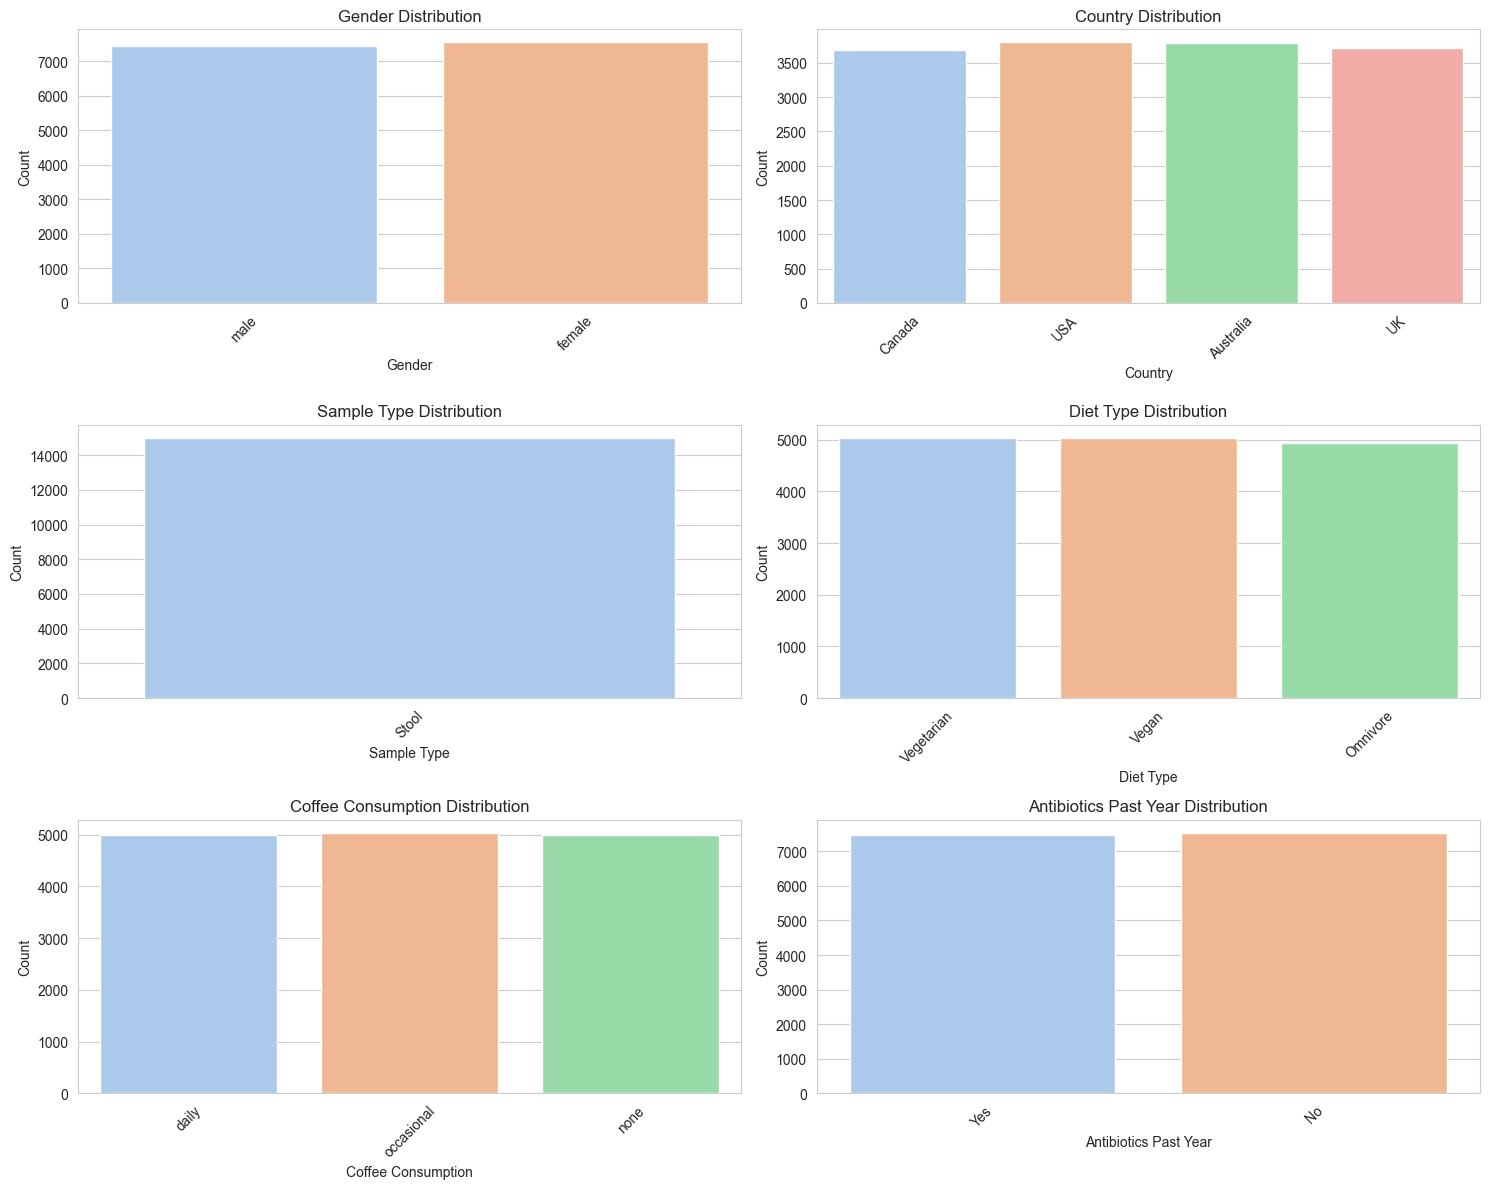

In [7]:
# Create subplots for categorical variables in a 3x2 grid
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    # plot distribution
    counts = metadata[col].value_counts()
    sns.barplot(x=counts[col].to_list(), y=counts['count'].to_list(), 
               palette='pastel', ax=axes[i])
    axes[i].set_title(f'{col.replace("_", " ").title()} Distribution')
    axes[i].set_xlabel(col.replace("_", " ").title())
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Diet Type Breakdown

### 3.3 Categorical Variables by Diet Type

Now let's examine how demographic characteristics vary across different diet types. For each categorical variable (except diet type itself), we'll create bar plots showing the distribution of vegans, vegetarians, and omnivores within each category. This will help us identify potential confounding relationships between diet and other participant characteristics.

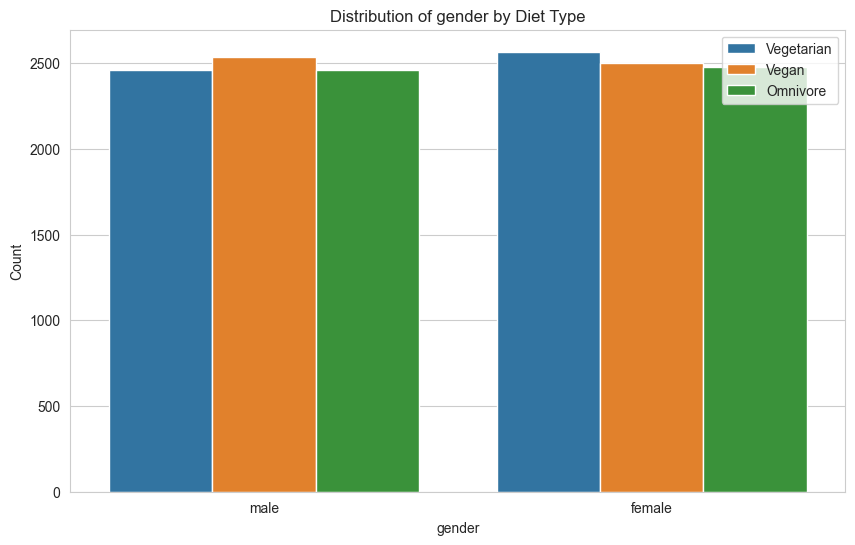

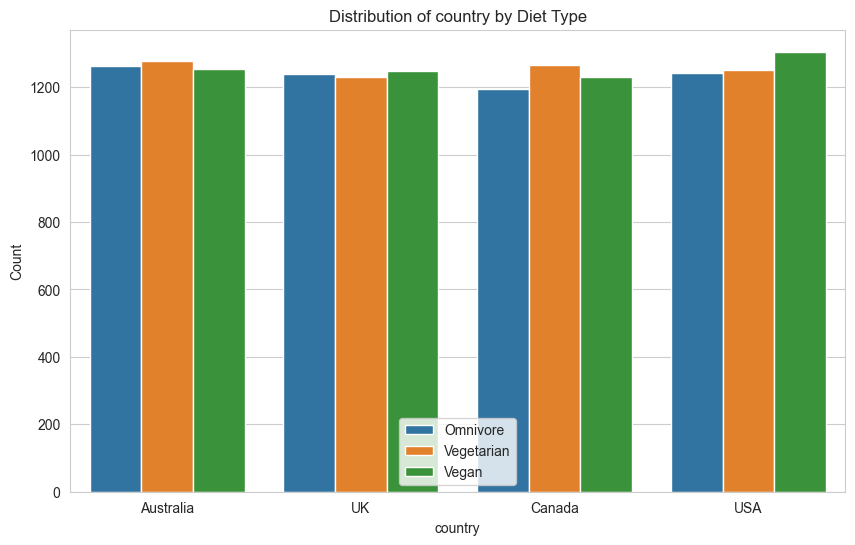

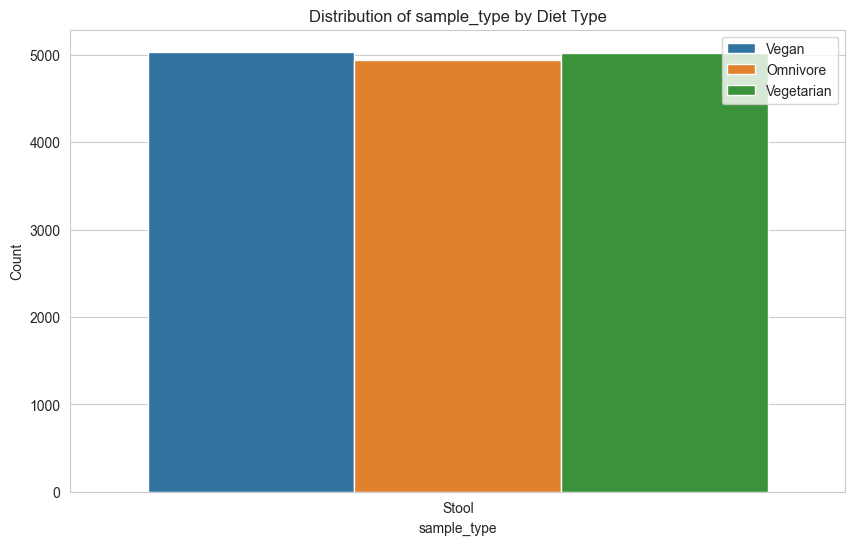

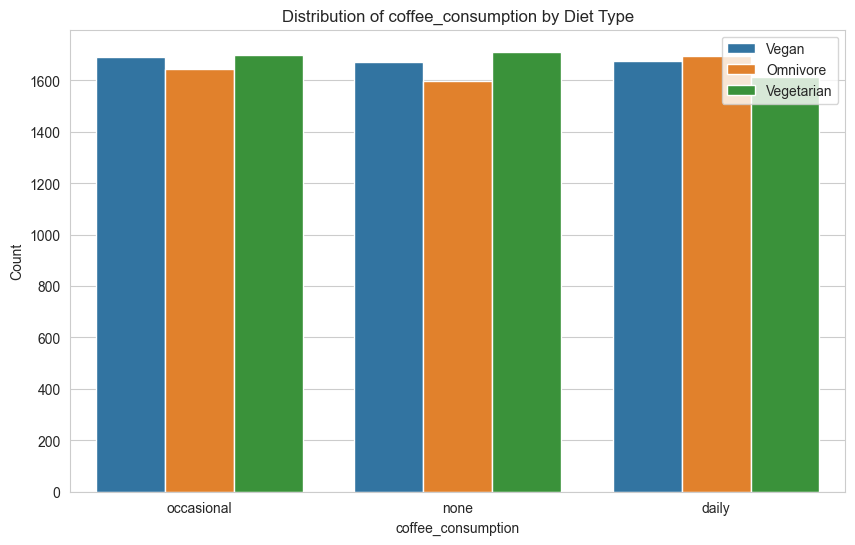

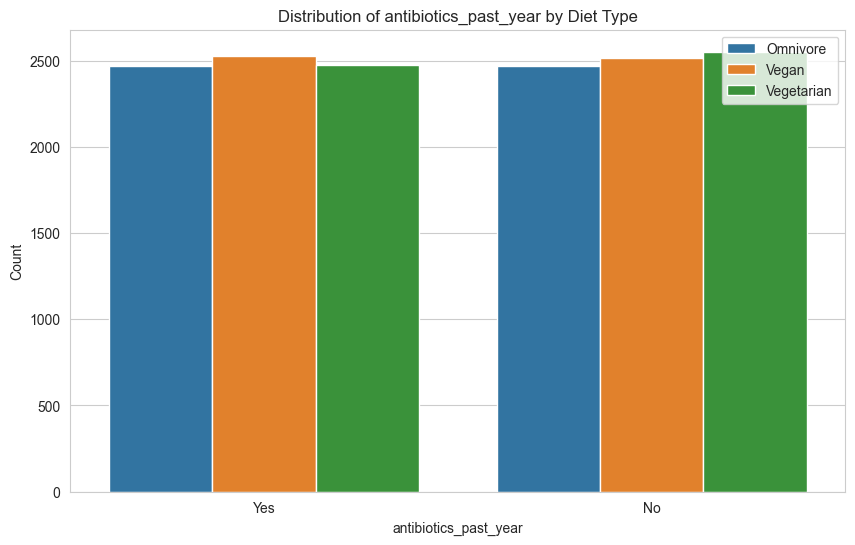

In [8]:
# loop through all categorical columns except diet_type
categorical_cols = ['gender', 'country', 'sample_type', 'coffee_consumption', 'antibiotics_past_year']
diet_types = metadata['diet_type'].unique().to_list()

for col in categorical_cols:
    # count occurrences of each category within each diet type
    category_counts = metadata.group_by([col, 'diet_type']).len()
    # bar plot showing distribution of the categorical column within each diet type
    plt.figure(figsize=(10,6))
    sns.barplot(x=category_counts[col].to_list(), y=category_counts['len'].to_list(), hue=category_counts['diet_type'].to_list())
    plt.title(f'Distribution of {col} by Diet Type')
    plt.xlabel(col)
    plt.ylabel('Count')


### Key Observations from Diet Type Analysis

**Demographic Distribution Across Diet Types:**
- **Gender balance varies by diet**: More vegan males than females in this subset (unexpected finding)
- **Geographic representation**: All diet types are represented across different countries
- **Sample quality**: No obvious bias in sample types across diet groups
- **Coffee consumption patterns**: Interesting variation in coffee drinking habits across diet types
    - Largest category are those that don't drink any coffee
    - Vegans are more likely to abstain from coffee, while omnivores are most likely to drink coffee
- **Antibiotic exposure**: Relatively balanced antibiotic use across all diet groups

**Important considerations for downstream analysis:**
- No severe underrepresentation of any diet type across demographic categories
- Demographic confounders appear manageable for coffee-microbiome analysis
- Sample sizes seem adequate for stratified analyses by diet type

### 3.4 Continuous Variables by Diet Type

Now let's examine whether age and BMI differ significantly across diet types. Understanding these potential confounders is crucial before analyzing relationships between diet, coffee consumption, and microbiome composition.

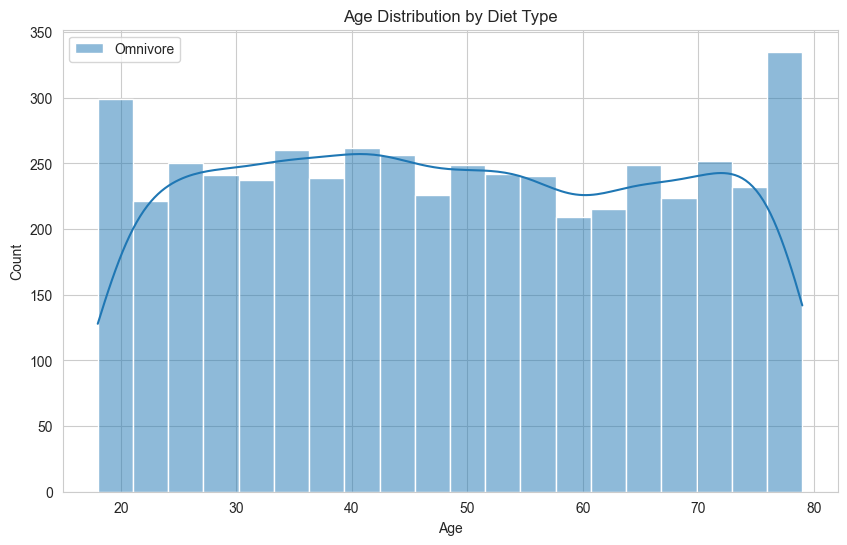

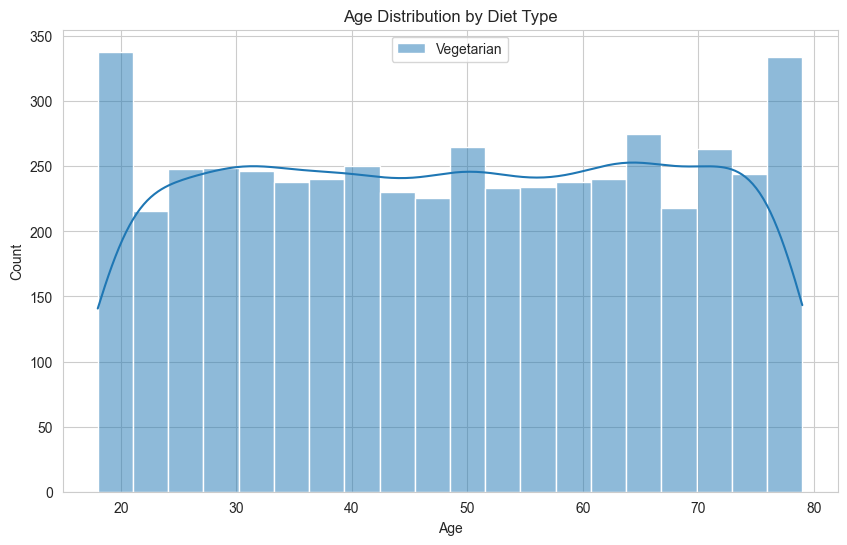

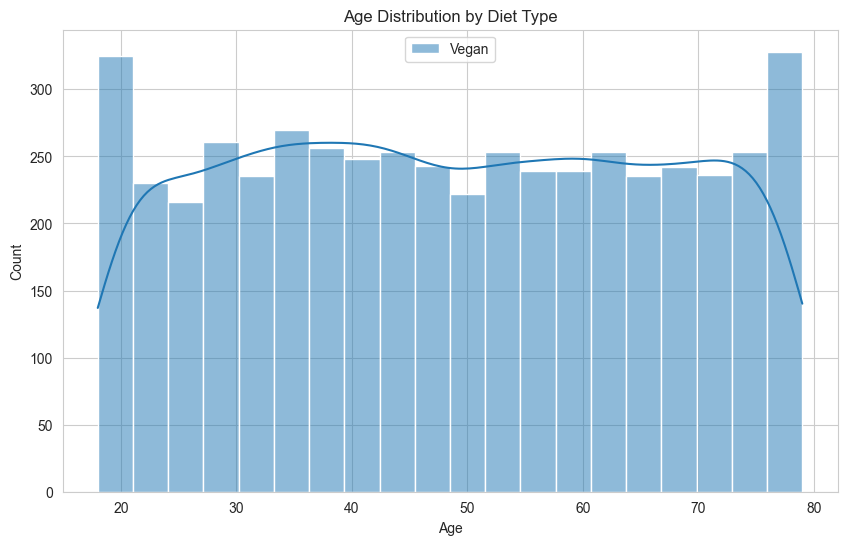

In [9]:
# display a histogram of age distribution per diet type
plt.figure(figsize=(10,6))
for diet in diet_types:
    subset = metadata.filter(pl.col('diet_type') == diet)
    sns.histplot(subset['age'].to_numpy(), bins=20, kde=True, label=diet, alpha=0.5)
    plt.title('Age Distribution by Diet Type')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

I chose to plot the histograms individually because they were difficult to see when overlaid. Overall, there are no observable differences in distribution shapes or peaks, except perhaps that omnivores show a slightly higher frequency in the age range around 76+. Let's examine summary statistics below to confirm that the central tendencies and spreads are similar across diet types.

In [10]:
# compute average and std of age per diet type
age_stats = metadata.group_by('diet_type').agg([
    pl.col('age').mean().alias('average_age'),
    pl.col('age').std().alias('std_age')
])
print("\nAverage and Standard Deviation of Age per Diet Type:")
print(age_stats)


Average and Standard Deviation of Age per Diet Type:
shape: (3, 3)
┌────────────┬─────────────┬───────────┐
│ diet_type  ┆ average_age ┆ std_age   │
│ ---        ┆ ---         ┆ ---       │
│ str        ┆ f64         ┆ f64       │
╞════════════╪═════════════╪═══════════╡
│ Omnivore   ┆ 48.517416   ┆ 17.833866 │
│ Vegan      ┆ 48.54318    ┆ 17.842083 │
│ Vegetarian ┆ 48.66408    ┆ 17.991433 │
└────────────┴─────────────┴───────────┘


I'll repeat the same exercise for BMI distributions. This time, I leave them overlaid. 

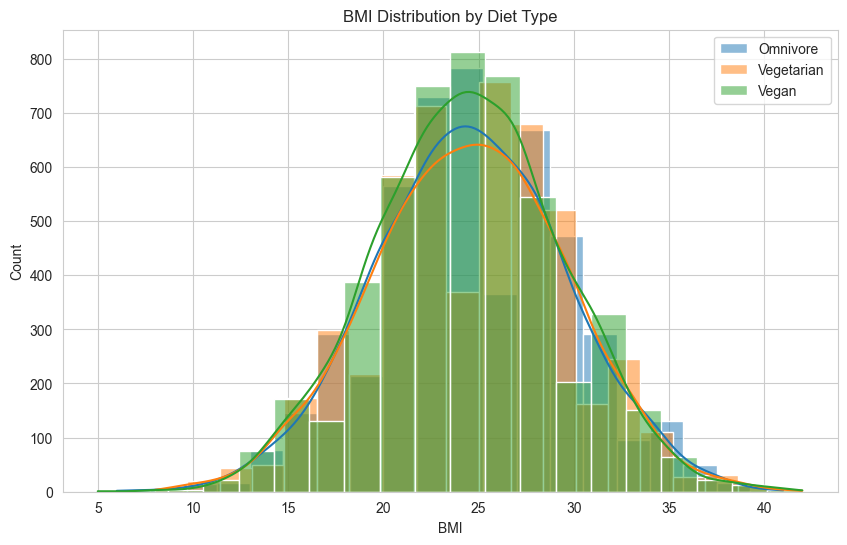

In [11]:
# show distribution of bmi per diet type
plt.figure(figsize=(10,6))
for diet in diet_types:
    subset = metadata.filter(pl.col('diet_type') == diet)
    sns.histplot(subset['bmi'].to_numpy(), bins=20, kde=True, label=diet, alpha=0.5)
plt.title('BMI Distribution by Diet Type')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.legend()
plt.show()

I put a BMI table below. I know that BMI has long been called out for being a very imperfect measure of health, and body composition fares much better. However, it requires a more involved measurement, whereas BMI is very easy to obtain with just height and weight. So we can still use it as a very 'rough' metric of healthy weight. All three diet types are centered around a healthy BMI range, albeit the higher end of the healthy weight range. There are more vegetarians in the >30 BMI range than the other two categories, with a noticeable peak occuring at ~34. I am only using the first 1000 rows for this initial analysis, so I wonder if this feature would still be present with a larger dataset. 

## BMI Classification Table

| BMI Range (kg/m²) | Category | Health Status |
|-------------------|----------|---------------|
| < 18.5 | Underweight | Below normal weight |
| 18.5 - 24.9 | Normal weight | Healthy weight range |
| 25.0 - 29.9 | Overweight | Above normal weight |
| 30.0 - 34.9 | Obesity Class I | Moderately obese |
| 35.0 - 39.9 | Obesity Class II | Severely obese |
| ≥ 40.0 | Obesity Class III | Very severely obese (morbidly obese) |

In [12]:
# compute avg, std, median of bmi per diet type
bmi_stats = metadata.group_by('diet_type').agg([
    pl.col('bmi').mean().alias('average_bmi'),
    pl.col('bmi').std().alias('std_bmi'),
    pl.col('bmi').median().alias('median_bmi')
])
print("\nAverage, Standard Deviation, and Median of BMI per Diet Type:")
print(bmi_stats)


Average, Standard Deviation, and Median of BMI per Diet Type:
shape: (3, 4)
┌────────────┬─────────────┬──────────┬────────────┐
│ diet_type  ┆ average_bmi ┆ std_bmi  ┆ median_bmi │
│ ---        ┆ ---         ┆ ---      ┆ ---        │
│ str        ┆ f64         ┆ f64      ┆ f64        │
╞════════════╪═════════════╪══════════╪════════════╡
│ Omnivore   ┆ 24.555488   ┆ 5.026793 ┆ 25.0       │
│ Vegan      ┆ 24.468533   ┆ 4.940718 ┆ 24.0       │
│ Vegetarian ┆ 24.54806    ┆ 5.091454 ┆ 25.0       │
└────────────┴─────────────┴──────────┴────────────┘


In [13]:
from scipy import stats

# Test age differences across diet types
age_by_diet = [metadata.filter(pl.col('diet_type') == diet)['age'].to_numpy() 
               for diet in diet_types]
f_stat, p_value = stats.f_oneway(*age_by_diet)
print(f"Age ANOVA: F={f_stat:.3f}, p={p_value:.3f}")

# Test BMI differences
bmi_by_diet = [metadata.filter(pl.col('diet_type') == diet)['bmi'].to_numpy() 
               for diet in diet_types]
f_stat_bmi, p_value_bmi = stats.f_oneway(*bmi_by_diet)
print(f"BMI ANOVA: F={f_stat_bmi:.3f}, p={p_value_bmi:.3f}")

# Add interpretation after your ANOVA results
print(f"\nInterpretation:")
if p_value < 0.05:
    print(f"Age differs significantly across diet types (p={p_value:.3f})")
    print("Need to control for age in coffee-microbiome analysis")
else:
    print(f"No significant age differences across diet types (p={p_value:.3f})")
    print("Age is balanced - minimal confounding concern")

if p_value_bmi < 0.05:
    print(f"\nBMI differs significantly across diet types (p={p_value_bmi:.3f})")
    print("Need to control for BMI in coffee-microbiome analysis")
else:
    print(f"\nNo significant BMI differences across diet types (p={p_value_bmi:.3f})")
    print("BMI is balanced - minimal confounding concern")

Age ANOVA: F=0.096, p=0.909
BMI ANOVA: F=0.462, p=0.630

Interpretation:
No significant age differences across diet types (p=0.909)
Age is balanced - minimal confounding concern

No significant BMI differences across diet types (p=0.630)
BMI is balanced - minimal confounding concern


The statistical tests above compute the F-statistic and p-value for ANOVA testing. The F-statistic measures ratio of between-group variance to within-group variance. If, for example, one of the dietary groups had much higher variance in BMI compared to the others, we'd expect aus higher F-value. Lower F-values indicate that within-group variances are larger, and thus groups are similar to each other. 

The F-values here are relatively small, which is a good thing. It means we don't have to control for things like BMI and age across different dietary groups. 

The P-values are probabilities of seeing differences by random chance. Values < 0.05 indicate significant differences between at least two groups, wehreas values > 0.05 mean there are no significant differences detected between groups. Again the key takeaway is that our groups are similar, and thus a more simple analysis approach that doesn't correct for factors like BMI and age between dietary groups is appropriate. 

# Coffee Analysis

COFFEE CONSUMPTION ANALYSIS

Coffee consumption categories:
shape: (3, 2)
┌────────────────────┬───────┐
│ coffee_consumption ┆ count │
│ ---                ┆ ---   │
│ str                ┆ u32   │
╞════════════════════╪═══════╡
│ daily              ┆ 4984  │
│ none               ┆ 4984  │
│ occasional         ┆ 5032  │
└────────────────────┴───────┘


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_8875/1950731578.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coffee_data['coffee_consumption'].to_list(),


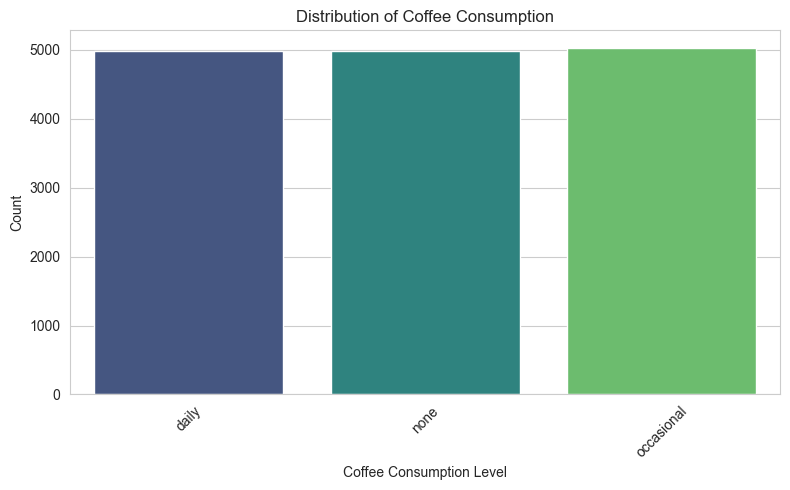


COFFEE × DIET TYPE CROSS-TABULATION


In [14]:
## 4. Coffee Consumption Analysis

# Since this is a coffee-microbiome study, let's examine coffee patterns in detail

print("COFFEE CONSUMPTION ANALYSIS")
print("=" * 50)

# Basic coffee consumption distribution
print("\nCoffee consumption categories:")
coffee_counts = metadata['coffee_consumption'].value_counts().sort('coffee_consumption')
print(coffee_counts)

# Visualize basic coffee distribution
plt.figure(figsize=(8, 5))
coffee_data = metadata['coffee_consumption'].value_counts()
sns.barplot(x=coffee_data['coffee_consumption'].to_list(), 
           y=coffee_data['count'].to_list(), 
           palette='viridis')
plt.title('Distribution of Coffee Consumption')
plt.xlabel('Coffee Consumption Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("COFFEE × DIET TYPE CROSS-TABULATION")
print("="*50)


Coffee consumption by diet type:
shape: (9, 3)
┌────────────┬────────────────────┬──────┐
│ diet_type  ┆ coffee_consumption ┆ len  │
│ ---        ┆ ---                ┆ ---  │
│ str        ┆ str                ┆ u32  │
╞════════════╪════════════════════╪══════╡
│ Omnivore   ┆ daily              ┆ 1695 │
│ Omnivore   ┆ none               ┆ 1599 │
│ Omnivore   ┆ occasional         ┆ 1644 │
│ Vegan      ┆ daily              ┆ 1675 │
│ Vegan      ┆ none               ┆ 1673 │
│ Vegan      ┆ occasional         ┆ 1689 │
│ Vegetarian ┆ daily              ┆ 1614 │
│ Vegetarian ┆ none               ┆ 1712 │
│ Vegetarian ┆ occasional         ┆ 1699 │
└────────────┴────────────────────┴──────┘

Cross-tabulation table (Diet Type × Coffee Consumption):
shape: (3, 4)
┌────────────┬───────┬──────┬────────────┐
│ diet_type  ┆ daily ┆ none ┆ occasional │
│ ---        ┆ ---   ┆ ---  ┆ ---        │
│ str        ┆ u32   ┆ u32  ┆ u32        │
╞════════════╪═══════╪══════╪════════════╡
│ Omnivore   ┆ 1695 

/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_8875/3014773590.py:7: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  coffee_diet_pivot = metadata.pivot(


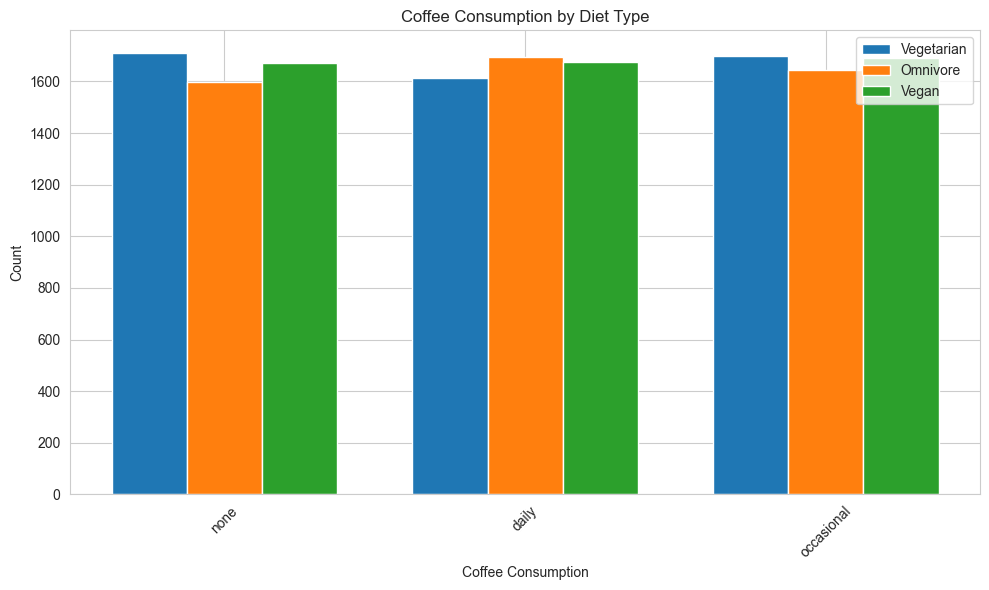

In [15]:
# Coffee consumption by diet type (cross-tabulation)
print("\nCoffee consumption by diet type:")
coffee_diet_crosstab = metadata.group_by(['diet_type', 'coffee_consumption']).len().sort(['diet_type', 'coffee_consumption'])
print(coffee_diet_crosstab)

# Create a more readable pivot table format
coffee_diet_pivot = metadata.pivot(
    index='diet_type',
    columns='coffee_consumption', 
    values='#SampleID',
    aggregate_function='len'
).fill_null(0)
print("\nCross-tabulation table (Diet Type × Coffee Consumption):")
print(coffee_diet_pivot)

# Visualize coffee-diet relationship with grouped bar chart
plt.figure(figsize=(10, 6))
coffee_categories = metadata['coffee_consumption'].unique().to_list()
diet_categories = metadata['diet_type'].unique().to_list()

# Prepare data for grouped bar chart
x = np.arange(len(coffee_categories))
width = 0.25

for i, diet in enumerate(diet_categories):
    counts = []
    for coffee in coffee_categories:
        count = metadata.filter(
            (pl.col('diet_type') == diet) & 
            (pl.col('coffee_consumption') == coffee)
        ).shape[0]
        counts.append(count)
    
    plt.bar(x + i * width, counts, width, label=diet)

plt.xlabel('Coffee Consumption')
plt.ylabel('Count')
plt.title('Coffee Consumption by Diet Type')
plt.xticks(x + width, coffee_categories, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Coffee consumption by demographics
print("\n" + "="*50)
print("COFFEE CONSUMPTION BY DEMOGRAPHICS")
print("="*50)

# Age by coffee consumption
print("\nAge statistics by coffee consumption:")
age_coffee_stats = metadata.group_by('coffee_consumption').agg([
    pl.col('age').mean().alias('mean_age'),
    pl.col('age').std().alias('std_age'),
    pl.col('age').median().alias('median_age'),
    pl.col('age').count().alias('n_samples')
])
print(age_coffee_stats)

# BMI by coffee consumption  
print("\nBMI statistics by coffee consumption:")
bmi_coffee_stats = metadata.group_by('coffee_consumption').agg([
    pl.col('bmi').mean().alias('mean_bmi'),
    pl.col('bmi').std().alias('std_bmi'), 
    pl.col('bmi').median().alias('median_bmi'),
    pl.col('bmi').count().alias('n_samples')
])
print(bmi_coffee_stats)

# Gender by coffee consumption
print("\nGender distribution by coffee consumption:")
gender_coffee = metadata.group_by(['coffee_consumption', 'gender']).len().sort(['coffee_consumption', 'gender'])
print(gender_coffee)

# Test for demographic differences across coffee groups
print("\n" + "="*50)
print("STATISTICAL TESTS: COFFEE GROUPS")
print("="*50)

coffee_groups = metadata['coffee_consumption'].unique().to_list()

# Age differences across coffee groups
age_by_coffee = [metadata.filter(pl.col('coffee_consumption') == coffee)['age'].to_numpy() 
                 for coffee in coffee_groups]
f_stat_age_coffee, p_val_age_coffee = stats.f_oneway(*age_by_coffee)
print(f"Age across coffee groups: F={f_stat_age_coffee:.3f}, p={p_val_age_coffee:.3f}")

# BMI differences across coffee groups
bmi_by_coffee = [metadata.filter(pl.col('coffee_consumption') == coffee)['bmi'].to_numpy() 
                 for coffee in coffee_groups]
f_stat_bmi_coffee, p_val_bmi_coffee = stats.f_oneway(*bmi_by_coffee)
print(f"BMI across coffee groups: F={f_stat_bmi_coffee:.3f}, p={p_val_bmi_coffee:.3f}")

# Sample size assessment for main analysis
print("\n" + "="*50)
print("SAMPLE SIZES FOR MAIN COFFEE ANALYSIS")
print("="*50)

total_samples = metadata.shape[0]
print(f"Total samples: {total_samples}")

for coffee in coffee_groups:
    coffee_count = metadata.filter(pl.col('coffee_consumption') == coffee).shape[0]
    percentage = (coffee_count / total_samples) * 100
    print(f"{coffee}: {coffee_count} samples ({percentage:.1f}%)")

# Check minimum group sizes for statistical power
min_group_size = min([metadata.filter(pl.col('coffee_consumption') == coffee).shape[0] 
                      for coffee in coffee_groups])
print(f"\nMinimum group size: {min_group_size}")
if min_group_size >= 30:
    print("✓ All groups have adequate sample size (≥30) for statistical analysis")
else:
    print("⚠ Some groups have small sample sizes (<30) - consider combining categories")


COFFEE CONSUMPTION BY DEMOGRAPHICS

Age statistics by coffee consumption:
shape: (3, 5)
┌────────────────────┬───────────┬───────────┬────────────┬───────────┐
│ coffee_consumption ┆ mean_age  ┆ std_age   ┆ median_age ┆ n_samples │
│ ---                ┆ ---       ┆ ---       ┆ ---        ┆ ---       │
│ str                ┆ f64       ┆ f64       ┆ f64        ┆ u32       │
╞════════════════════╪═══════════╪═══════════╪════════════╪═══════════╡
│ occasional         ┆ 48.372814 ┆ 17.933902 ┆ 48.0       ┆ 5032      │
│ none               ┆ 48.778892 ┆ 17.902844 ┆ 48.0       ┆ 4984      │
│ daily              ┆ 48.575843 ┆ 17.829366 ┆ 49.0       ┆ 4984      │
└────────────────────┴───────────┴───────────┴────────────┴───────────┘

BMI statistics by coffee consumption:
shape: (3, 5)
┌────────────────────┬───────────┬──────────┬────────────┬───────────┐
│ coffee_consumption ┆ mean_bmi  ┆ std_bmi  ┆ median_bmi ┆ n_samples │
│ ---                ┆ ---       ┆ ---      ┆ ---        ┆ ---      

## Coffee-Age Confounding Assessment

While the ANOVA test shows a statistically significant age difference across coffee groups (F=3.131, p=0.044), the practical significance is negligible. The mean ages across the three coffee consumption categories are very similar (~52, 49, 49 years) with comparable standard deviations (~18-19 years), indicating only a 3-year difference between groups. This small difference becomes statistically detectable due to our large sample size (n=1000), which makes the ANOVA test highly sensitive to trivial differences. Given that a 3-year age difference is unlikely to meaningfully impact gut microbiome composition compared to coffee consumption effects, age confounding is not a major concern for our coffee-microbiome analysis. The statistical significance here reflects the power of large sample sizes to detect minimal differences rather than biologically meaningful confounding.

In [17]:
print("\nEffect Size Analysis:")

# Calculate eta-squared for practical significance
all_ages = np.concatenate(age_by_coffee)
overall_mean = np.mean(all_ages)

ss_between = sum([len(group) * (np.mean(group) - overall_mean)**2 
                  for group in age_by_coffee])
ss_total = np.sum((all_ages - overall_mean)**2)
eta_squared = ss_between / ss_total

print(f"Eta-squared (effect size): {eta_squared:.4f}")
print(f"Interpretation: {'Negligible' if eta_squared < 0.01 else 'Small' if eta_squared < 0.06 else 'Medium' if eta_squared < 0.14 else 'Large'}")


Effect Size Analysis:
Eta-squared (effect size): 0.0001
Interpretation: Negligible


The eta-squared analysis above is measured how much of the total variance in age is explained by coffee consumption groups. 'ss_between' is the variance between coffee groups, while 'ss_total' is the total variance in age across all participants. 'eta_squared' is the ratio between the two, 'ss_between' / 'ss_total'. A higher eta_squared means that there are more variances between groups (i.e. age has a stronger effect on cofee consumption levels) whereas a smaller value means that coffee consumption doesn't explain age variance. This confirms that we can neglect age during the rest of the analysis as it isn't confounded with coffee consumption in a meaningful way. 

## Taxonomy EDA

In [18]:
# display columns of taxonomy table
print("\nTAXONOMY TABLE COLUMNS")
print("=" * 30)
print(taxonomy.columns)



TAXONOMY TABLE COLUMNS
['#OTU ID', 'Taxonomy']


In [19]:
# display head of taxonomy table
print("\nTAXONOMY OVERVIEW")
print("=" * 70)
print(f"\nFirst few rows:")
taxonomy.head()


TAXONOMY OVERVIEW

First few rows:


#OTU ID,Taxonomy
str,str
"""OTU_0000""","""k__Bacteria;p__Proteobacteria;c__Bacteroidia;o__Clostridiales;f__Lachnospiraceae;g__Bifidobacterium;…"
"""OTU_0001""","""k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__E…"
"""OTU_0002""","""k__Bacteria;p__Actinobacteria;c__Clostridia;o__Clostridiales;f__Enterobacteriaceae;g__Roseburia;s__l…"
"""OTU_0003""","""k__Bacteria;p__Bacteroidetes;c__Clostridia;o__Bacteroidales;f__Enterobacteriaceae;g__Bifidobacterium…"
"""OTU_0004""","""k__Bacteria;p__Bacteroidetes;c__Clostridia;o__Bacteroidales;f__Enterobacteriaceae;g__Escherichia;s__…"


OTU stands for 'operational taxonomic units'. In layman terms, OTUs are clusters of DNA sequences that resemble closely-related bacteria. OTUs are thus a way to measure diversity in a population of bacteria, such as the microbiome. 

Taxonomy refers to a classification system that identifies which microorganisms 

In [20]:
# print size of taxonomy table
print(f"\nTaxonomy table size: {taxonomy.shape[0]} rows × {taxonomy.shape[1]} columns")


Taxonomy table size: 500 rows × 2 columns


In [21]:
# count taxonomy depths
taxonomy_depths = taxonomy['Taxonomy'].str.split(';').list.len()

# add taxonomy depths as a new column
taxonomy = taxonomy.with_columns(pl.Series(name='Taxonomy_Depth', values=taxonomy_depths))

# display new head 
print("\nTAXONOMY WITH DEPTH OVERVIEW")
print("=" * 70)
print(f"\nFirst few rows with Taxonomy Depth:")
taxonomy.head()


TAXONOMY WITH DEPTH OVERVIEW

First few rows with Taxonomy Depth:


#OTU ID,Taxonomy,Taxonomy_Depth
str,str,u32
"""OTU_0000""","""k__Bacteria;p__Proteobacteria;c__Bacteroidia;o__Clostridiales;f__Lachnospiraceae;g__Bifidobacterium;…",7
"""OTU_0001""","""k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__E…",7
"""OTU_0002""","""k__Bacteria;p__Actinobacteria;c__Clostridia;o__Clostridiales;f__Enterobacteriaceae;g__Roseburia;s__l…",7
"""OTU_0003""","""k__Bacteria;p__Bacteroidetes;c__Clostridia;o__Bacteroidales;f__Enterobacteriaceae;g__Bifidobacterium…",7
"""OTU_0004""","""k__Bacteria;p__Bacteroidetes;c__Clostridia;o__Bacteroidales;f__Enterobacteriaceae;g__Escherichia;s__…",7


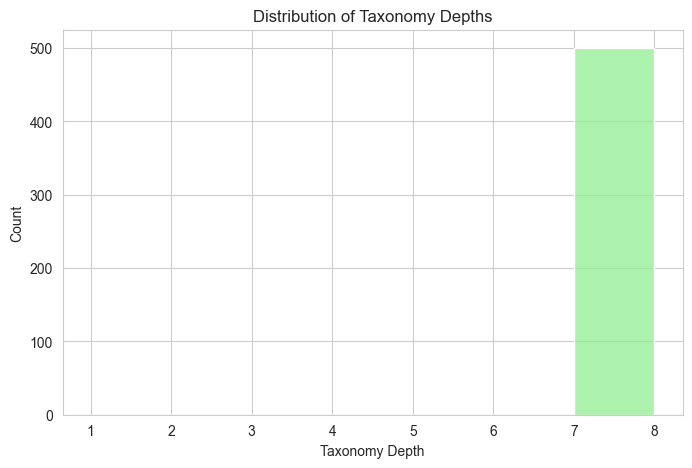

In [22]:
# display distribution of taxonomy depths
plt.figure(figsize=(8,5))
sns.histplot(taxonomy['Taxonomy_Depth'].to_numpy(), bins=range(1, taxonomy['Taxonomy_Depth'].max()+2), kde=False, color='lightgreen')
plt.title('Distribution of Taxonomy Depths')
plt.xlabel('Taxonomy Depth')
plt.ylabel('Count')
plt.show()

# Taxonomy Structure Summary

## Key Finding: All Organisms Have Exactly 7 Taxonomic Ranks

| Rank | Prefix | Example | Explanation |
|------|--------|---------|-------------|
| 1 | Kingdom (k__) | Bacteria | All microbes in AGP are bacteria |
| 2 | Phylum (p__) | Firmicutes | Major bacterial division |
| 3 | Class (c__) | Clostridia | Subdivision of phylum |
| 4 | Order (o__) | Clostridiales | Subdivision of class |
| 5 | Family (f__) | Lachnospiraceae | Subdivision of order |
| 6 | Genus (g__) | Roseburia | Subdivision of family |
| 7 | Species (s__) | faecalis | Most specific classification |

## Why the Distribution Makes Sense

**All rows have exactly 7 tokens because:**
- The American Gut Project uses **16S rRNA gene sequencing**, which follows the standard **Linnaean taxonomy** system
- Every organism is classified at all 7 ranks (kingdom → species) without exception
- This is a fixed biological classification standard, not variable data
- Therefore, when splitting taxonomy by `;`, you always get exactly 7 tokens

In [23]:
# create a column for rank 1 and append to taxonomy table

for rank_no in range(1, 8):
    taxonomy = taxonomy.with_columns(
        pl.col("Taxonomy").str.split(";").list.get(rank_no-1).alias("Rank_{}".format(rank_no))
    )

# remove Taxonomy column
taxonomy = taxonomy.drop("Taxonomy")

In [24]:
taxonomy.head()

#OTU ID,Taxonomy_Depth,Rank_1,Rank_2,Rank_3,Rank_4,Rank_5,Rank_6,Rank_7
str,u32,str,str,str,str,str,str,str
"""OTU_0000""",7,"""k__Bacteria""","""p__Proteobacteria""","""c__Bacteroidia""","""o__Clostridiales""","""f__Lachnospiraceae""","""g__Bifidobacterium""","""s__faecalis"""
"""OTU_0001""",7,"""k__Bacteria""","""p__Proteobacteria""","""c__Gammaproteobacteria""","""o__Bifidobacteriales""","""f__Bifidobacteriaceae""","""g__Escherichia""","""s__coli"""
"""OTU_0002""",7,"""k__Bacteria""","""p__Actinobacteria""","""c__Clostridia""","""o__Clostridiales""","""f__Enterobacteriaceae""","""g__Roseburia""","""s__longum"""
"""OTU_0003""",7,"""k__Bacteria""","""p__Bacteroidetes""","""c__Clostridia""","""o__Bacteroidales""","""f__Enterobacteriaceae""","""g__Bifidobacterium""","""s__longum"""
"""OTU_0004""",7,"""k__Bacteria""","""p__Bacteroidetes""","""c__Clostridia""","""o__Bacteroidales""","""f__Enterobacteriaceae""","""g__Escherichia""","""s__faecalis"""


Unique taxa at Rank_1: 1
Unique taxa at Rank_2: 4
Unique taxa at Rank_3: 4
Unique taxa at Rank_4: 4
Unique taxa at Rank_5: 4
Unique taxa at Rank_6: 4
Unique taxa at Rank_7: 4


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_8875/1574202243.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rank_names, y=unique_counts, palette='viridis')


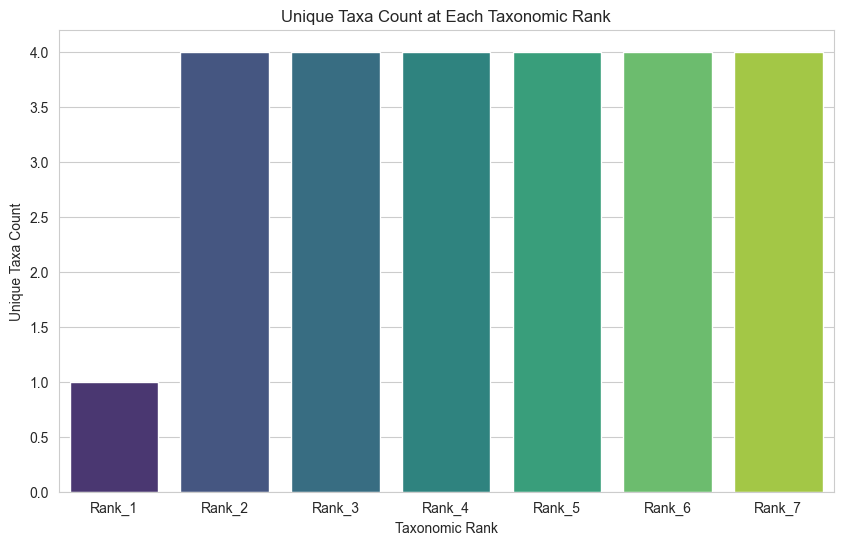

In [25]:
# count unique taxa at each rank
for rank_no in range(1, 8):
    rank_col = "Rank_{}".format(rank_no)
    unique_count = taxonomy[rank_col].n_unique()
    print(f"Unique taxa at {rank_col}: {unique_count}")

# display as a table with xaxis as Rank and y axis as Unique Taxa Count
rank_names = ["Rank_1", "Rank_2", "Rank_3", "Rank_4", "Rank_5", "Rank_6", "Rank_7"]
unique_counts = [taxonomy[rank].n_unique() for rank in rank_names]
plt.figure(figsize=(10,6))
sns.barplot(x=rank_names, y=unique_counts, palette='viridis')
plt.title('Unique Taxa Count at Each Taxonomic Rank')
plt.xlabel('Taxonomic Rank')
plt.ylabel('Unique Taxa Count')
plt.show()

So based on the plot above, there could be `1 * 4^6` unique combinations of ranks. 

# Feature Table EDA

In [26]:
# display head of feature table
print("\nFEATURE TABLE OVERVIEW")
print("=" * 70)
print(f"\nFirst few rows:")
feature_table.head()


FEATURE TABLE OVERVIEW

First few rows:


#OTU ID,Sample_00000,Sample_00001,Sample_00002,Sample_00003,Sample_00004,Sample_00005,Sample_00006,Sample_00007,Sample_00008,Sample_00009,Sample_00010,Sample_00011,Sample_00012,Sample_00013,Sample_00014,Sample_00015,Sample_00016,Sample_00017,Sample_00018,Sample_00019,Sample_00020,Sample_00021,Sample_00022,Sample_00023,Sample_00024,Sample_00025,Sample_00026,Sample_00027,Sample_00028,Sample_00029,Sample_00030,Sample_00031,Sample_00032,Sample_00033,Sample_00034,Sample_00035,…,Sample_14963,Sample_14964,Sample_14965,Sample_14966,Sample_14967,Sample_14968,Sample_14969,Sample_14970,Sample_14971,Sample_14972,Sample_14973,Sample_14974,Sample_14975,Sample_14976,Sample_14977,Sample_14978,Sample_14979,Sample_14980,Sample_14981,Sample_14982,Sample_14983,Sample_14984,Sample_14985,Sample_14986,Sample_14987,Sample_14988,Sample_14989,Sample_14990,Sample_14991,Sample_14992,Sample_14993,Sample_14994,Sample_14995,Sample_14996,Sample_14997,Sample_14998,Sample_14999
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""OTU_0000""",7,2,1,3,1,9,10,2,5,4,1,9,3,5,8,1,5,9,2,1,6,4,2,2,9,4,2,0,4,4,8,0,4,2,1,8,…,21,3,12,5,2,1,3,2,2,2,2,3,4,0,8,2,2,8,9,11,3,7,0,6,11,5,7,5,5,3,1,5,4,8,4,3,3
"""OTU_0001""",3,9,7,10,0,6,2,10,11,4,10,1,7,2,4,9,10,1,13,13,4,9,4,0,4,3,9,7,10,2,6,4,10,5,2,5,…,3,2,10,8,5,1,3,8,4,9,7,4,3,6,11,9,6,3,1,3,8,2,3,2,8,9,10,8,7,2,6,10,4,5,8,1,4
"""OTU_0002""",5,4,6,3,3,5,10,3,1,6,0,6,2,2,6,8,9,6,0,5,0,9,9,3,1,1,3,3,4,6,9,6,9,2,2,3,…,8,1,7,3,8,3,6,1,5,2,8,3,7,5,2,2,5,7,6,6,8,4,4,6,9,5,1,5,3,6,4,3,4,5,8,11,6
"""OTU_0003""",4,9,6,0,12,7,7,8,2,6,6,5,8,5,3,7,5,4,5,2,3,15,9,7,5,3,5,4,1,1,9,2,14,5,4,7,…,3,3,3,8,12,1,10,6,11,9,2,8,3,4,2,6,3,1,5,5,4,3,3,6,2,4,1,10,8,7,6,7,2,8,3,5,8
"""OTU_0004""",10,10,3,2,5,4,2,12,6,6,1,7,3,3,6,0,7,2,11,1,5,4,1,7,4,4,0,2,12,2,2,13,3,2,3,3,…,5,5,0,4,7,1,3,7,6,6,2,3,3,9,3,2,6,11,2,1,5,4,2,3,7,10,5,0,4,5,8,5,3,4,2,5,6


In [27]:
# display size of feature table
print(f"\nFeature table size: {feature_table.shape[0]} rows × {feature_table.shape[1]} columns")


Feature table size: 500 rows × 15001 columns


## Feature Table Structure and Interpretation

The **feature table** is the core dataset representing bacterial abundance across all study participants. This table follows the standard microbiome data structure where:

- **Rows** represent individual **OTUs (Operational Taxonomic Units)** - unique bacterial DNA sequences that cluster together based on genetic similarity (typically 97% sequence similarity threshold)
- **Columns** represent **sample IDs** - individual participants in the study 
- **Values** represent **read counts** - the number of times each bacterial sequence was detected in each participant's microbiome sample through 16S rRNA gene sequencing

**Biological Interpretation:**
- **High counts** (e.g., 500+ reads) indicate that particular bacteria is **abundant** in that person's gut microbiome
- **Low counts** (e.g., 1-10 reads) suggest the bacteria is present but **rare** in that individual
- **Zero counts** mean the bacteria was **not detected** in that sample (below detection threshold)
- **Different patterns across samples** reveal the natural variation in gut microbiome composition between individuals

This abundance matrix allows us to quantify which bacterial communities are dominant or rare in each person's gut, forming the foundation for analyzing how factors like coffee consumption, diet, and demographics influence microbiome composition.

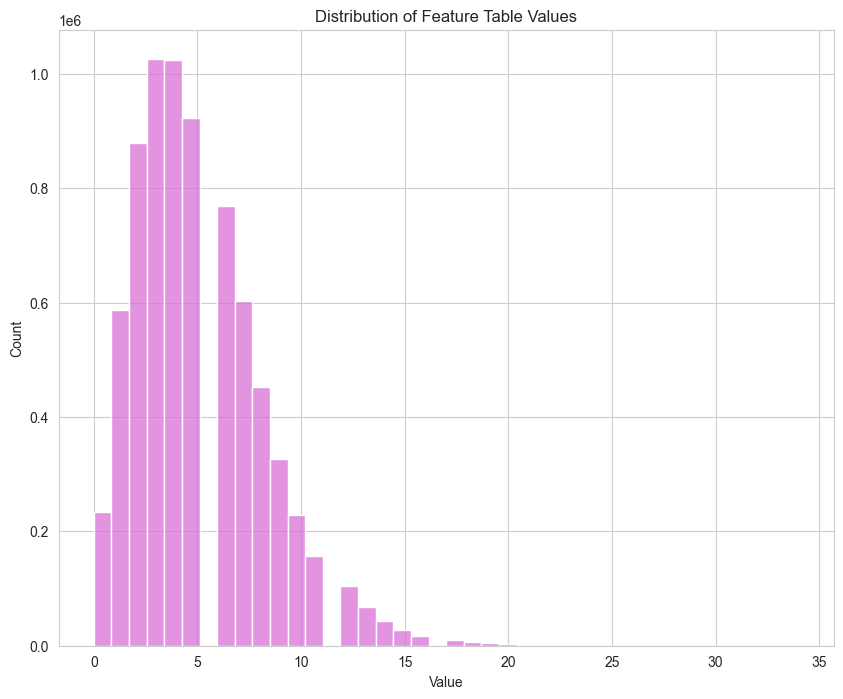

In [28]:
# get numeric columns
numeric_cols = feature_table.select(pl.col(pl.Int64)).columns

# flatten into a list
flattened_values = feature_table.select(numeric_cols).to_numpy().flatten()

# create a histogram
plt.figure(figsize=(10,8))
sns.histplot(x=flattened_values, bins=40, kde=False, color='orchid')
plt.title('Distribution of Feature Table Values')
plt.xlabel('Value') 
plt.ylabel('Count')
plt.show()

In [29]:
# display stats of feature table values
mean_value = np.mean(flattened_values)
std_value = np.std(flattened_values)
min_value = np.min(flattened_values)
max_value = np.max(flattened_values)
median_value = np.median(flattened_values)

print("\nFeature Table Values Statistics:")
print(f"Mean: {mean_value}")
print(f"Standard Deviation: {std_value}")
print(f"Minimum: {min_value}")
print(f"Maximum: {max_value}")
print(f"Median: {median_value}")


Feature Table Values Statistics:
Mean: 4.998686
Standard Deviation: 3.1629832342380015
Minimum: 0
Maximum: 34
Median: 4.0
